## 🧩 Task 1: Sequential Agent Workflow (LangGraph + Google Gemini)

This notebook demonstrates a basic sequential workflow using **LangGraph** where each step depends on the output of the previous one.

We integrate **Google Gemini** via a LangChain-compatible wrapper to simulate reasoning over multiple substeps:
- Step 1: Generate a topic
- Step 2: Expand it into a blog outline
- Step 3: Turn it into a paragraph

We'll also visualize the agent flow using **networkx** and show debug traces.


In [5]:
# Install necessary packages
!pip install -q langgraph langchain-google-genai networkx matplotlib



In [34]:
import os
from google.colab import userdata
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')


In [11]:
from typing import TypedDict
from langgraph.graph import StateGraph
from langchain_core.runnables import RunnableLambda
from langchain_google_genai import ChatGoogleGenerativeAI
import os
from google.colab import userdata

In [14]:
import google.generativeai as genai
models = genai.list_models()
for model in models:
    print(model.name)

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.5-pro-preview-03-25
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01

In [15]:
# Define the state schema
class BlogState(TypedDict):
    topic: str
    outline: str
    paragraph: str

# Initialize the model
model = ChatGoogleGenerativeAI(model="gemini-1.5-pro", temperature=0.5)

# Define node functions
def generate_topic(state: BlogState) -> dict:
    response = model.invoke("Suggest a trending AI topic.")
    return {"topic": response.content}

def expand_outline(state: BlogState) -> dict:
    response = model.invoke(f"Write a blog outline on: {state['topic']}")
    return {"outline": response.content}

def write_paragraph(state: BlogState) -> dict:
    response = model.invoke(f"Write a blog paragraph based on outline: {state['outline']}")
    return {"paragraph": response.content}

# Construct the LangGraph workflow with the defined state schema
builder = StateGraph(BlogState)
builder.add_node("Generate Topic", RunnableLambda(generate_topic))
builder.add_node("Expand Outline", RunnableLambda(expand_outline))
builder.add_node("Write Paragraph", RunnableLambda(write_paragraph))

builder.set_entry_point("Generate Topic")
builder.add_edge("Generate Topic", "Expand Outline")
builder.add_edge("Expand Outline", "Write Paragraph")
builder.set_finish_point("Write Paragraph")

graph = builder.compile()

# Execute the graph
output = graph.invoke({})
print("Final Paragraph Output:\n", output["paragraph"])

Final Paragraph Output:
 The generative AI revolution is upon us, transforming the way we create and consume content.  This cutting-edge technology, which generates new content from existing data, is rapidly evolving, buzzing with advancements in text, image, video, and audio generation. From crafting compelling marketing copy to producing stunning visuals and even composing original music, generative AI is reshaping content creation across industries, presenting both exciting opportunities and significant challenges that we must address.  This transformative technology promises increased efficiency and personalized experiences, but also raises concerns about plagiarism, bias, and the potential displacement of human creativity.  Join us as we explore the fascinating world of generative AI and its impact on the future of content.


## 📊 Visualization: Sequential Workflow Graph

Below is a visual representation of the sequential agent path using `networkx`. Each node corresponds to a single task in the agent pipeline.


In [16]:
!pip install networkx matplotlib


In [17]:
import networkx as nx
import matplotlib.pyplot as plt


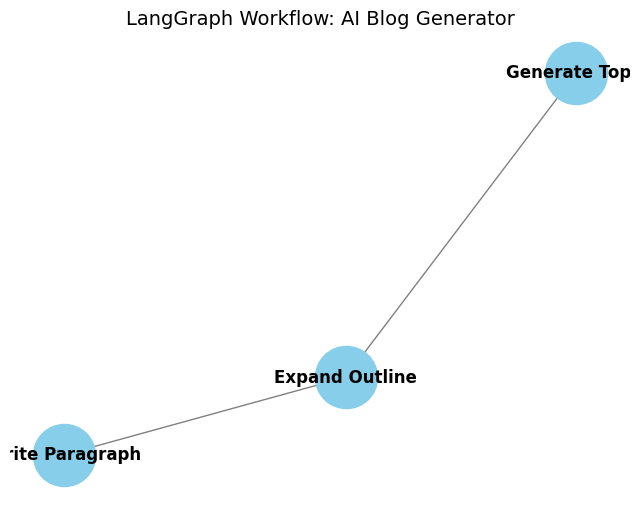

In [22]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_node("Generate Topic")
G.add_node("Expand Outline")
G.add_node("Write Paragraph")

# Add edges to represent the workflow
G.add_edge("Generate Topic", "Expand Outline")
G.add_edge("Expand Outline", "Write Paragraph")

# Define the layout for the graph
pos = nx.spring_layout(G)

# Draw the nodes and edges
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=2000)
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Set the title and remove axes
plt.title("LangGraph Workflow: AI Blog Generator", fontsize=14)
plt.axis('off')

# Display the graph
plt.show()


In [19]:
!pip install graphviz


In [21]:
from graphviz import Digraph

def visualize_workflow():
    dot = Digraph(comment="LangGraph Workflow: AI Blog Generator")
    dot.attr(rankdir='LR', size='8,5')

    # Define nodes with custom styles
    dot.node('A', 'Generate Topic', shape='box', style='filled', color='lightblue')
    dot.node('B', 'Expand Outline', shape='box', style='filled', color='lightgreen')
    dot.node('C', 'Write Paragraph', shape='box', style='filled', color='lightpink')

    # Define edges with labels
    dot.edge('A', 'B', label='Topic to Outline')
    dot.edge('B', 'C', label='Outline to Paragraph')

    # Render and display the graph
    return dot

workflow_graph = visualize_workflow()
workflow_graph.render('langgraph_workflow', format='png', cleanup=True)
workflow_graph.view()



'langgraph_workflow.pdf'

## 🔍 Task: Enable LangSmith Studio Tracing

LangSmith Studio allows you to **monitor, debug, and trace** your LangGraph runs in real time. This is extremely useful for understanding agent behavior and debugging issues.

In this step:
- We'll configure LangSmith
- Enable tracing
- Run the graph and log the trace


In [24]:
# Step 1: Install langsmith SDK if not already installed
!pip install -q langsmith

# Step 2: Set LangSmith environment variables
import os
from google.colab import userdata

# Replace these values with your actual LangSmith credentials
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "LangGraph_Agent_Trace"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.langchain.plus"

print("✅ LangSmith configuration loaded.")


✅ LangSmith configuration loaded.


In [25]:
from langgraph.graph import StateGraph
from langsmith.wrappers import wrap_openai
from langchain_core.runnables import RunnableLambda
from typing import TypedDict

# Wrap Gemini model with LangSmith if needed (you can skip if you're using Google models directly)
# Example placeholder: wrapped_model = wrap_openai(model)

class BlogState(TypedDict):
    topic: str
    outline: str
    paragraph: str

# Reuse your existing model and functions (already defined above)

builder = StateGraph(BlogState)
builder.add_node("Generate Topic", RunnableLambda(generate_topic))
builder.add_node("Expand Outline", RunnableLambda(expand_outline))
builder.add_node("Write Paragraph", RunnableLambda(write_paragraph))

builder.set_entry_point("Generate Topic")
builder.add_edge("Generate Topic", "Expand Outline")
builder.add_edge("Expand Outline", "Write Paragraph")
builder.set_finish_point("Write Paragraph")

graph = builder.compile()

# 🚀 Trace this execution using LangSmith
print("🚀 Running traced LangGraph workflow...")
output = graph.invoke({})
print("📄 Final Paragraph:\n", output["paragraph"])


🚀 Running traced LangGraph workflow...
📄 Final Paragraph:
 From crafting fantastical images from mere text prompts to composing symphonies in seconds, generative AI is rapidly transforming the landscape of content creation.  Tools like DALL-E 2, Midjourney, and Stable Diffusion are empowering anyone with an internet connection to become a digital artist, conjuring breathtaking visuals previously only achievable by skilled professionals.  Meanwhile, language models like GPT-3 are churning out blog posts, marketing copy, and even movie scripts, blurring the lines between human and machine authorship.  This explosion of creative potential, however, comes with its own set of challenges.  Questions of copyright, ownership, and the very definition of creativity are being fiercely debated as we grapple with the implications of this powerful new technology.  While the future impact remains uncertain, one thing is clear: generative AI is revolutionizing how we create and consume content, usheri

## 🧠 Task 2: Branching Agent Workflow (LangGraph + Gemini)

In this workflow, we demonstrate how an agent can follow **different paths** based on a user's preference. This is key in adaptive agent behavior.

- If user preference = `"education"` → summarize AI news
- If user preference = `"fun"` → generate a nerdy AI joke

We'll use a conditional node in LangGraph and visualize the branch.


In [28]:
from typing import TypedDict
from langgraph.graph import StateGraph
from langchain_core.runnables import RunnableLambda
import os

# Define schema
class BranchState(TypedDict):
    preference: str
    content: str

# Node logic
def decide_path(state: BranchState) -> str:
    return "summarize" if state["preference"] == "education" else "joke"

def summarize(state: BranchState) -> dict:
    content = model.invoke("Summarize the latest breakthroughs in AI.").content
    return {"content": content}

def joke(state: BranchState) -> dict:
    content = model.invoke("Tell me a nerdy AI joke.").content
    return {"content": content}

# Build graph
branch_graph = StateGraph(BranchState)
branch_graph.add_node("summarize", RunnableLambda(summarize))
branch_graph.add_node("joke", RunnableLambda(joke))
# A new node called "start" which is a runnable lambda that simply returns an empty dictionary
# This is because there is no function to execute on the start node and there are only conditional edges coming from it
branch_graph.add_node("start", RunnableLambda(lambda x: {}))
branch_graph.add_conditional_edges(
    "start",
    lambda state: decide_path(state),
    {"summarize": "summarize", "joke": "joke"},
)
branch_graph.set_entry_point("start")
branch_graph.set_finish_point("summarize")
branch_graph.set_finish_point("joke")

compiled_branch_graph = branch_graph.compile()

In [29]:
# Test: Education path
print("🧠 Education Preference")
output_edu = compiled_branch_graph.invoke({"preference": "education"})
print("📘 Output:\n", output_edu["content"])

# Test: Fun path
print("\n🎉 Fun Preference")
output_fun = compiled_branch_graph.invoke({"preference": "fun"})
print("🤣 Output:\n", output_fun["content"])


🧠 Education Preference
📘 Output:
 Recent breakthroughs in AI span several areas, making it difficult to give a truly exhaustive list. However, some key advancements include:

* **Multimodal AI:**  Models like Gemini,  are capable of understanding and generating content across different modalities like text, images, audio, and video. This opens doors for richer human-computer interaction and more versatile AI applications.

* **Generative AI for creative content:**  Significant improvements have been seen in text generation (e.g., more coherent and contextually relevant long-form writing), image synthesis (e.g., generating realistic images from text descriptions with tools like DALL-E 3 and Midjourney), video generation (though still nascent), and even music composition.

* **Reinforcement Learning from Human Feedback (RLHF):** This technique has been crucial in aligning large language models with human preferences, leading to more helpful and less harmful outputs. It allows models to l

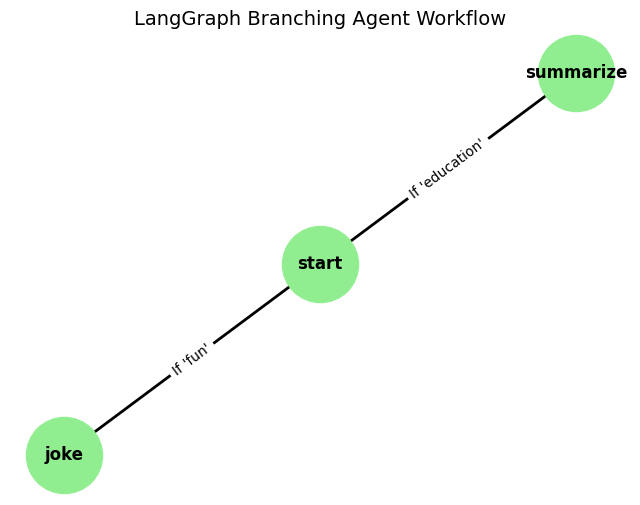

In [30]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_node("start", label="User Preference")
G.add_node("summarize", label="Summarize AI News")
G.add_node("joke", label="Tell AI Joke")

G.add_edge("start", "summarize", label="If 'education'")
G.add_edge("start", "joke", label="If 'fun'")

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_color='lightgreen', node_size=3000)
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle="->", width=2)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("LangGraph Branching Agent Workflow", fontsize=14)
plt.axis('off')
plt.show()


## 🔁 Task 3: Retry & Loop Agent Workflow

This task demonstrates a retry loop behavior where the agent **retries** a task until a condition is satisfied.

Scenario:
- The agent generates an AI-related sentence.
- If the sentence does **not contain the keyword "AI"**, it **retries** generation.

This kind of loop is helpful for:
- Data validation
- Human-in-the-loop feedback
- Output quality assurance


In [32]:
from langgraph.graph import StateGraph
from langchain_core.runnables import RunnableLambda
from typing import TypedDict

class RetryState(TypedDict):
    sentence: str
    retry_count: int

# Generator node
def generate_sentence(state: RetryState) -> dict:
    response = model.invoke("Write a sentence about technology.").content
    return {"sentence": response, "retry_count": state.get("retry_count", 0) + 1}

# Validator node
def validate_sentence(state: RetryState) -> str:
    return "accept" if "AI" in state["sentence"] else "retry"

# Build graph
loop_graph = StateGraph(RetryState)
loop_graph.add_node("generate", RunnableLambda(generate_sentence))
loop_graph.add_node("accept", RunnableLambda(lambda x: x))

# Conditional loop: validate and decide
loop_graph.add_conditional_edges(
    "generate",
    validate_sentence,
    {
        "retry": "generate",  # Loop back if condition not met
        "accept": "accept",   # Finish if condition met
    },
)

loop_graph.set_entry_point("generate")
loop_graph.set_finish_point("accept")

compiled_loop_graph = loop_graph.compile()
